In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_curve, auc, confusion_matrix 



warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Logistic Regression

In [13]:
# Read in data
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [15]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [16]:
# Remove unecessary columns from beginning of data ('Unnamed: 0', 'customerid')
df2 = df.iloc[:,2:]
df2.head(2)

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [18]:
# Replace churn string values with numeric binary values
df2.Churn.replace({"Yes":1, "No":0}, inplace = True)
# Utilize pandas dummy variable function to create dummy variable series for categorical data
dummy_df = pd.get_dummies(df2)
dummy_df.to_csv('final_df.csv')
dummy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Columns: 6574 entries, SeniorCitizen to TotalCharges_999.9
dtypes: float64(1), int64(3), uint8(6570)
memory usage: 44.3 MB


# Visualizing Correlations

In [ ]:
# Plot correlations between our features and our target feature, churn, as a bar plot, sort by descending order
dummy_df.corr()['churn'].sort_values(ascending = False).plot('bar', figsize = (20, 10), color = 'Navy')
plt.title('Feature Correlation w/ Churn', fontsize = 30, fontweight = 'bold')
plt.xticks(fontsize = 15, fontweight = 'bold')
plt.yticks(fontweight = 'bold', fontsize = 12)

plt.tight_layout()

In [ ]:
# Visualize a heatmap for our features correlation values
plt.figure(figsize = (30, 15))
x = sns.heatmap(dummy_df.corr(), cmap = 'YlGnBu')

From our heatmap and correlation barplot, we see that monthly contract, and a lack of online security or techsupport have the strongest positive correlation with churn. 2-Year Contracts and not having internet service are the most negatively correlated with churn.

# Pre-Processing Data for Logistic Regression

In [22]:
# Establish our target feature, churn, as our y feature
y = dummy_df.Churn.values
# Drop our target feature from our features dataframe
X = dummy_df.drop('Churn', axis = 1)
# Save dataframe column titles to list for reassigning after min max scale 
cols = X.columns

#  Scaling our Data

In [23]:
# Instantiate min-max scaling object
mm = MinMaxScaler()
# Fit and transform our feature dataframe
X = pd.DataFrame(mm.fit_transform(X))
# Reassign column names so new dataframe has corresponding names
X.columns = cols

# Train Test Split

In [24]:
# Perform train test split from our target feature series and the predicting feature dataframe (set test size to 25% of data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 33)

# Building the Model

In [25]:
# Instantiate a Logistic Regression model without an intercept. C is set to an arbitrarily large number. Use 'liblinear' solver method.
logreg = LogisticRegression(fit_intercept = False, C = 1e12, solver = 'liblinear')
# Fit the model to our X and y training sets
logreg.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [27]:
# Generate model prediction data for train and test sets
y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)

# Evaluating Model Performance

In [28]:
# Find residual differences between train data and predicted train data
residuals = np.abs(y_train - y_hat_train)
# Print value counts of our predicted values 
print(pd.Series(residuals).value_counts())
print('----------------------------------')
# Print normalized value counts of our predicted values
print(pd.Series(residuals).value_counts(normalize = True))

0    5222
1      60
dtype: int64
----------------------------------
0    0.988641
1    0.011359
dtype: float64


Train Set Results:
4270 Correct (1012 Incorrect)
80.8 % Accuracy

In [29]:
# Repeat previous step with test data
residuals = np.abs(y_test - y_hat_test)
print(pd.Series(residuals).value_counts())
print('---------------------------------')
print(pd.Series(residuals).value_counts(normalize = True))

0    1347
1     414
dtype: int64
---------------------------------
0    0.764906
1    0.235094
dtype: float64


Test Set Results:
1409 Correct (352 Incorrect)
80.01% Accuracy

# Confusion Matrix

In [30]:
# Call confusion_matrix function from sklearn.metrics using actual y_test and predicted y_test data sets 
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print('Confusion Matrix: \n', cnf_matrix)

Confusion Matrix: 
 [[1133  148]
 [ 266  214]]


In [62]:
import regression_module

In [63]:
# Print 4 main logistic model metrics for training and test sets (Precision, Recall, Accuracy, F1)
print_metrics(y_train, y_hat_train, y_test, y_hat_test)

Training Metrics:
Training Precision:  0.98
Training Recall:  0.98
Training Accuracy:  0.99
Training F1-Score:  0.98


Testing Metrics:
Testing Precision:  0.59
Testing Recall:  0.45
Testing Accuracy:  0.76
Testing F1-Score:  0.51


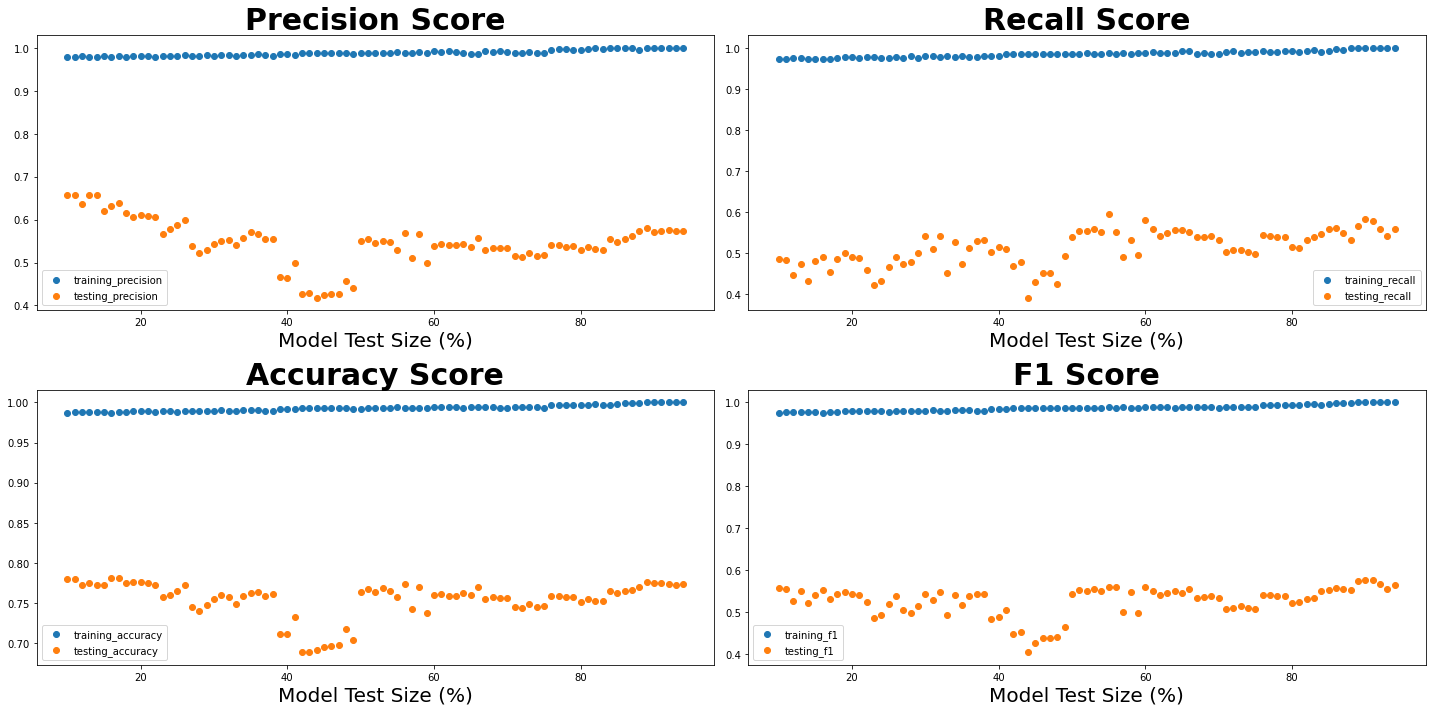

In [64]:
# Print residual scatter plot for 4 main logistic model metrics, iterating through the model and passing multiple 
# test-size objects to visualize effects of train/test size on model performance
print_metric_comparisons(X, y)

Plot ROC Curves
We will now calculate probability scores for our y-train and y-test datasets. We use the false positive and true positive rates to plot a ROC Curve (receiver operating characteristic curve) for both train and test sets.

Training AUC: 0.9995603228700348
Test AUC: 0.7957081056466303


FileNotFoundError: [Errno 2] No such file or directory: 'pics/Regression_pics/roc_curve.png'

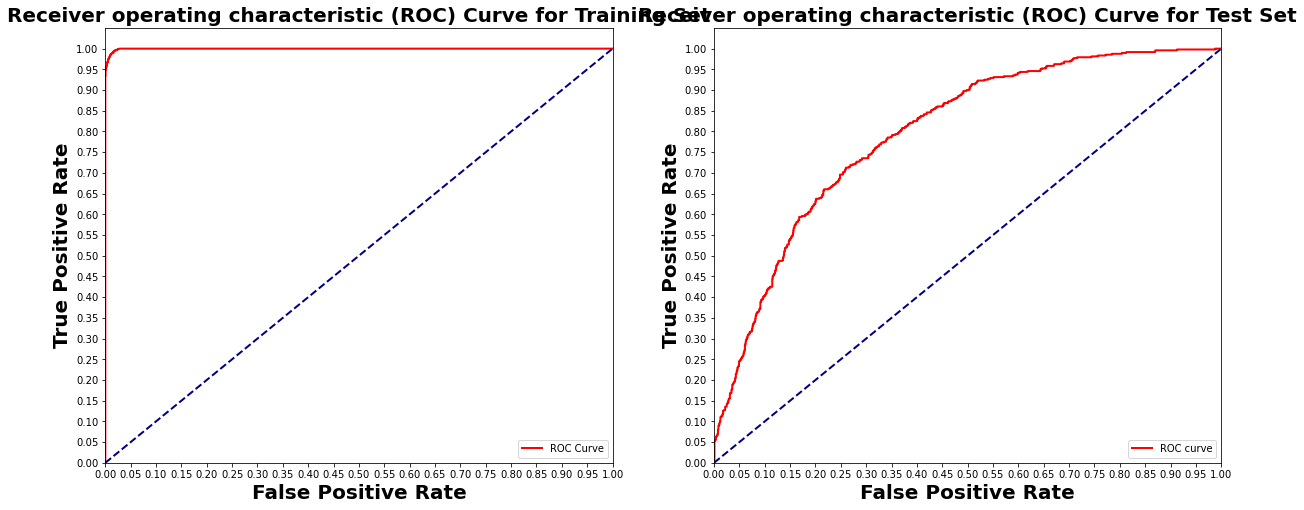

In [68]:
plot_auc(logreg, X_train, X_test, y_train, y_test)